In [1]:
import pandas as pd
import numpy as np
import os
import time
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train__2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    kdd_test__2labels = pd.read_pickle("dataset/kdd_test__2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")

In [3]:
dataset.kdd_train_2labels.shape

(25192, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
dataset.kdd_test__2labels.shape

(11850, 124)

In [6]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]
    
    x_test__input = dataset.kdd_test__2labels.drop(output_columns_2labels, axis = 1)
    y_test_ = dataset.kdd_test__2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    x_test_ = ss.transform(x_test__input)

    y_train = y_output.values
    y_test = y_test.values
    y_test_ = y_test_.values

    
preprocess.x_train.shape

(25192, 122)

In [7]:
import tensorflow as tf
from tensorflow.contrib.legacy_seq2seq.python.ops.seq2seq import basic_rnn_seq2seq
from tensorflow.contrib.rnn import RNNCell, LSTMCell, MultiRNNCell

In [1]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 3
    latent_dim = 10

    hidden_decoder_dim = 122
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x_input = tf.placeholder("float", shape=[None, 1, input_dim])
            self.y_input_ = tf.placeholder("float", shape=[None, 1, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
            self.x_list = tf.unstack(self.x_input, axis= 1)
            self.y_list_ = tf.unstack(self.y_input_, axis = 1)
            self.y_ = self.y_list_[0]
            
            #GO = tf.fill((tf.shape(self.x)[0], 1), 0.5)
            
            #y_with_GO = tf.stack([self.y_, GO])
            
        with tf.variable_scope("lstm"):
            multi_cell = MultiRNNCell([LSTMCell(input_dim) for i in range(hidden_layers)] )
            
            self.y, states = basic_rnn_seq2seq(self.x_list, self.y_list_, multi_cell)
            #self.y = tf.slice(self.y, [0, 0], [-1,2])
            
            #self.out = tf.squeeze(self.y)
            
            #self.y = tf.layers.dense(self.y[0], classes, activation = None)
            
            self.y = tf.slice(self.y[0], [0, 0], [-1,2])
            
        with tf.variable_scope("Loss"):
            
            self.regularized_loss = tf.losses.mean_squared_error(self.y_, self.y)
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()

In [9]:
import collections
import sklearn.metrics as me

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'f1_score', 'test_score_20', 'f1_score_20', 'time_taken'])

    predictions = {}
    predictions_ = {}

    results = []
    best_acc = 0
    best_acc_global = 0

    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_lstm_nsl_kdd-orig-/hidden layers_{}_features count_{}".format(h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            
            accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x_input: preprocess.x_test[:,np.newaxis,:], 
                                                                             net.y_input_: preprocess.y_test[:,np.newaxis,:], 
                                                                             net.keep_prob:1})
            
            print("Initial Accuracy, before training: {}".format(accuracy))
            
            for c, lr in enumerate(lrs):
                for epoch in range(1, (epochs+1)):
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        _, train_loss = sess.run([net.train_op, net.regularized_loss], #net.summary_op
                                                              feed_dict={net.x_input: x_train[i,np.newaxis,:], 
                                                                         net.y_input_: y_train[i,np.newaxis,:], 
                                                                         net.keep_prob:1, net.lr:lr})
                        #summary_writer_train.add_summary(summary_str, epoch)
                        if(train_loss > 1e9):
                            print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))


                    valid_accuracy,valid_loss = sess.run([net.tf_accuracy, net.regularized_loss], #net.summary_op 
                                                          feed_dict={net.x_input: x_valid[:,np.newaxis,:], 
                                                                     net.y_input_: y_valid[:,np.newaxis,:], 
                                                                     net.keep_prob:1, net.lr:lr})
                    #summary_writer_valid.add_summary(summary_str, epoch)



                    accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x_input: preprocess.x_test[:,np.newaxis,:], 
                                                                             net.y_input_: preprocess.y_test[:,np.newaxis,:], 
                                                                             net.keep_prob:1, net.lr:lr})
                    f1_score = me.f1_score(actual_value, pred_value)
                    accuracy_, pred_value_, actual_value_, y_pred_ = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x_input: preprocess.x_test_[:,np.newaxis,:], 
                                                                             net.y_input_: preprocess.y_test_[:,np.newaxis,:], 
                                                                             net.keep_prob:1, net.lr:lr})
                    f1_score_ = me.f1_score(actual_value_, pred_value_)
                    print("Step {} | Training Loss: {:.6f} | Train Accuracy: {:.6f} | Test Accuracy: {:.6f}, {:.6f}".format(epoch, train_loss, valid_accuracy, accuracy, accuracy_))

                    if accuracy > Train.best_acc_global:
                                Train.best_acc_global = accuracy
                                Train.pred_value = pred_value
                                Train.actual_value = actual_value
                                Train.pred_value_ = pred_value_
                                Train.actual_value_ = actual_value_
                                Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:

                        #net.saver.save(sess, "dataset/tf_vae_only_nsl_kdd_hidden layers_{}_features count_{}".format(epochs,h,f))
                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
                        #curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
                        #Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})

                        Train.best_acc = accuracy
                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_lstm_nsl_kdd-orig-/hidden layers_{}_features count_{}/model"
                                       .format(h,f), 
                                       global_step = epoch, 
                                       write_meta_graph=False)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value, "Actual":actual_value})
                        curr_pred_ = pd.DataFrame({"Attack_prob":y_pred_[:,-2], "Normal_prob":y_pred_[:, -1], "Prediction":pred_value_, "Actual": actual_value_})
                        Train.predictions.update({"{}_{}_{}".format((epochs+1)* (c+1),f,h):
                                                  (curr_pred,
                                                   Train.result((epochs+1)*(c+1), f, h,valid_accuracy, accuracy, f1_score, accuracy_, f1_score_, time.perf_counter() - start_time))})
                        Train.predictions_.update({"{}_{}_{}".format((epochs+1)* (c+1),f,h):
                                                  (curr_pred_,
                                                   Train.result((epochs+1)*(c+1), f, h,valid_accuracy, accuracy, f1_score, accuracy_, f1_score_, time.perf_counter() - start_time))})

In [10]:
import itertools

df_results = []
past_scores = []

class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]

    def start_training():

        global df_results
        global past_scores
        
        Train.predictions = {}
        Train.results = []
        
        features_arr = [30, 61, 91, 122] #[4, 8, 16, 32]
        hidden_layers_arr = [1, 3]

        epochs = [10]
        lrs = [1e-2]

        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)
            
        dict1 = {}
        dict1_ = {}
        dict2 = []
        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)

        for k, (v1_, v2) in Train.predictions_.items():
            dict1_.update({k: v1_})

            
        Train.predictions = dict1
        Train.predictions_ = dict1_

        Train.results = dict2
        df_results = pd.DataFrame(Train.results)
        temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        if not os.path.isfile('dataset/scores/tf_lstm_nsl_kdd-orig_all27-.pkl'):
            past_scores = temp
        else:
            past_scores = pd.read_pickle("dataset/scores/tf_lstm_nsl_kdd-orig_all27-.pkl")

        past_scores.append(temp).to_pickle("dataset/scores/tf_lstm_nsl_kdd-orig_all27-.pkl")

In [11]:
Hyperparameters.start_training()

Current Layer Attributes - epochs:10 hidden layers:1 features count:30
Initial Accuracy, before training: 0.25762951374053955
Step 1 | Training Loss: 0.013333 | Train Accuracy: 0.989683 | Test Accuracy: 0.768630, 0.559831
Step 2 | Training Loss: 0.001301 | Train Accuracy: 0.998016 | Test Accuracy: 0.805092, 0.629198
Step 3 | Training Loss: 0.004859 | Train Accuracy: 0.998810 | Test Accuracy: 0.846301, 0.707595
Step 4 | Training Loss: 0.001275 | Train Accuracy: 0.999603 | Test Accuracy: 0.881565, 0.774684
Step 5 | Training Loss: 0.002083 | Train Accuracy: 1.000000 | Test Accuracy: 0.894917, 0.800084
Step 6 | Training Loss: 0.001355 | Train Accuracy: 0.999603 | Test Accuracy: 0.885158, 0.781519
Step 7 | Training Loss: 0.001038 | Train Accuracy: 1.000000 | Test Accuracy: 0.899663, 0.809114
Step 8 | Training Loss: 0.001819 | Train Accuracy: 1.000000 | Test Accuracy: 0.894784, 0.799831
Step 9 | Training Loss: 0.001195 | Train Accuracy: 1.000000 | Test Accuracy: 0.895094, 0.800422
Step 10 | 

Step 6 | Training Loss: 0.000648 | Train Accuracy: 0.990873 | Test Accuracy: 0.997294, 0.996034
Step 7 | Training Loss: 0.005067 | Train Accuracy: 0.992857 | Test Accuracy: 0.997294, 0.996034
Step 8 | Training Loss: 0.009486 | Train Accuracy: 0.996032 | Test Accuracy: 0.997250, 0.995949
Step 9 | Training Loss: 0.005067 | Train Accuracy: 0.991667 | Test Accuracy: 0.997205, 0.995865
Step 10 | Training Loss: 0.009486 | Train Accuracy: 0.990873 | Test Accuracy: 0.997205, 0.995865


In [12]:
pd.Panel(Train.predictions).to_pickle("dataset/LSTM/tf_lstm_nsl_kdd_predictions112.pkl")
pd.Panel(Train.predictions_).to_pickle("dataset/LSTM/tf_lstm_nsl_kdd_predictions112__.pkl")

df_results.to_pickle("dataset/LSTM/tf_lstm_nsl_kdd_scores112.pkl")

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Negative", "\n False Positive \n Type II Error"],
             ["\n False Negative \n Type I Error", "\n True Positive"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix

    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, ['Normal', 'Attack'], normalize = False)

In [14]:
past_scores = pd.read_pickle("dataset/scores/tf_lstm_nsl_kdd-orig_all27-.pkl")

In [15]:
past_scores.sort_values(by='f1_score',ascending=False)

epoch  train_score  test_score  f1_score  \
no_of_features hidden_layers                                             
30             3                 11     1.000000    0.999379  0.999455   
               3                 11     1.000000    0.999379  0.999455   
91             3                 11     1.000000    0.999157  0.999260   
               3                 11     1.000000    0.999157  0.999260   
61             3                 11     1.000000    0.998181  0.998405   
               3                 11     1.000000    0.998181  0.998405   
122            3                 11     0.993651    0.997472  0.997784   
               3                 11     0.993651    0.997472  0.997784   
               1                 11     0.999603    0.901615  0.910064   
               1                 11     0.999603    0.901615  0.910064   
91             1                 11     1.000000    0.899796  0.907800   
               1                 11     1.000000    0.899796  0.907800   
30             1                 11     1.000000    0.899663  0.907764   
               1                 11     1.000000    0.899663  0.907764   
61             1                 11     0.999603    0.884271  0.892372   
               1                 11     0.999603    0.884271  0.892372   

                              test_score_20  f1_score_20  time_taken  
no_of_features hidden_layers                                          
30             3                   0.998819     0.999279   39.666082  
               3                   0.998819     0.999279   39.666082  
91             3                   0.998397     0.999021   68.287103  
               3                   0.998397     0.999021   68.287103  
61             3                   0.996540     0.997891   31.114994  
               3                   0.996540     0.997891   31.114994  
122            3                   0.996371     0.997788   58.270466  
               3                   0.996371     0.997788   58.270466  
               1                   0.812827     0.879404   25.546331  
               1                   0.812827     0.879404   25.546331  
91             1                   0.809367     0.876090   23.152842  
               1                   0.809367     0.876090   23.152842  
30             1                   0.809114     0.876082   19.044960  
               1                   0.809114     0.876082   19.044960  
61             1                   0.779831     0.854822   18.329451  
               1                   0.779831     0.854822   18.329451

In [16]:
psg = past_scores.sort_values(by='test_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
psg.first().sort_values(by='test_score', ascending=False)

epoch  train_score  test_score  f1_score  \
no_of_features hidden_layers                                             
30             3                 11     1.000000    0.999379  0.999455   
91             3                 11     1.000000    0.999157  0.999260   
61             3                 11     1.000000    0.998181  0.998405   
122            3                 11     0.993651    0.997472  0.997784   
               1                 11     0.999603    0.901615  0.910064   
91             1                 11     1.000000    0.899796  0.907800   
30             1                 11     1.000000    0.899663  0.907764   
61             1                 11     0.999603    0.884271  0.892372   

                              test_score_20  f1_score_20  time_taken  
no_of_features hidden_layers                                          
30             3                   0.998819     0.999279   39.666082  
91             3                   0.998397     0.999021   68.287103  
61             3                   0.996540     0.997891   31.114994  
122            3                   0.996371     0.997788   58.270466  
               1                   0.812827     0.879404   25.546331  
91             1                   0.809367     0.876090   23.152842  
30             1                   0.809114     0.876082   19.044960  
61             1                   0.779831     0.854822   18.329451

In [17]:
psg.mean().sort_values(by='test_score', ascending=False)

epoch  train_score  test_score  f1_score  \
no_of_features hidden_layers                                             
30             3                 11     1.000000    0.999379  0.999455   
91             3                 11     1.000000    0.999157  0.999260   
61             3                 11     1.000000    0.998181  0.998405   
122            3                 11     0.993651    0.997472  0.997784   
               1                 11     0.999603    0.901615  0.910064   
91             1                 11     1.000000    0.899796  0.907800   
30             1                 11     1.000000    0.899663  0.907764   
61             1                 11     0.999603    0.884271  0.892372   

                              test_score_20  f1_score_20  time_taken  
no_of_features hidden_layers                                          
30             3                   0.998819     0.999279   39.666082  
91             3                   0.998397     0.999021   68.287103  
61             3                   0.996540     0.997891   31.114994  
122            3                   0.996371     0.997788   58.270466  
               1                   0.812827     0.879404   25.546331  
91             1                   0.809367     0.876090   23.152842  
30             1                   0.809114     0.876082   19.044960  
61             1                   0.779831     0.854822   18.329451

In [18]:
Train.predictions = pd.read_pickle("dataset/LSTM/tf_lstm_nsl_kdd_predictions112.pkl")
Train.predictions_ = pd.read_pickle("dataset/LSTM/tf_lstm_nsl_kdd_predictions112__.pkl")

In [19]:
Train.predictions

<class 'pandas.core.panel.Panel'>
Dimensions: 8 (items) x 22544 (major_axis) x 4 (minor_axis)
Items axis: 11_122_1 to 11_91_3
Major_axis axis: 0 to 22543
Minor_axis axis: Actual to Prediction

In [20]:
Train.predictions["11_91_3"].sample()

,Actual,Attack_prob,Normal_prob,Prediction
3489,1.0,0.000944,0.96368,1.0


In [21]:
Train.predictions_

<class 'pandas.core.panel.Panel'>
Dimensions: 8 (items) x 11850 (major_axis) x 4 (minor_axis)
Items axis: 11_122_1 to 11_91_3
Major_axis axis: 0 to 11849
Minor_axis axis: Actual to Prediction

In [22]:
Train.predictions_["11_91_3"].sample()

,Actual,Attack_prob,Normal_prob,Prediction
11741,0.0,0.963917,0.00019,0.0


In [23]:
df = Train.predictions["11_91_3"].dropna()
df_ = Train.predictions_["11_91_3"].dropna()

In [24]:
from sklearn import metrics as me
def get_score(y_true, y_pred):
    f1 = me.f1_score(y_true, y_pred)
    pre = me.precision_score(y_true, y_pred)
    rec = me.recall_score(y_true, y_pred)
    acc = me.accuracy_score(y_true, y_pred)
    return {"F1 Score":f1, "Precision":pre, "Recall":rec, "Accuracy":acc}

In [25]:
from sklearn import metrics as me

scores = get_score(df.loc[:,'Actual'].values.astype(int),
                df.loc[:,'Prediction'].values.astype(int))
scores.update({"Scenario":"Train-/Test+"})
score_df = pd.DataFrame(scores, index=[0])


scores = get_score(df_.loc[:,'Actual'].values.astype(int),
                df_.loc[:,'Prediction'].values.astype(int))
scores.update({"Scenario":"Train-/Test-"})
#score_df = pd.DataFrame(scores, index=[0])
score_df = score_df.append(pd.DataFrame(scores, index=[1]))

score_df

,Accuracy,F1 Score,Precision,Recall,Scenario
0,0.999157,0.999260,0.998522,1.0,Train-/Test+
1,0.998397,0.999021,0.998045,1.0,Train-/Test-


In [26]:
df.groupby(by="Actual").Actual.count()

Actual
0.0     9711
1.0    12833
Name: Actual, dtype: int64

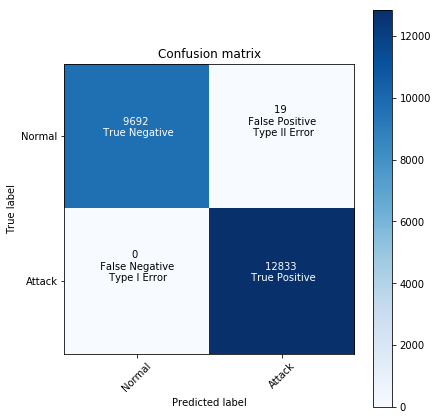

In [27]:
plot(actual_value = df.loc[:,'Actual'].values.astype(int),
     pred_value = df.loc[:,'Prediction'].values.astype(int))

In [28]:
df_.groupby(by="Actual").Actual.count()

Actual
0.0    2152
1.0    9698
Name: Actual, dtype: int64

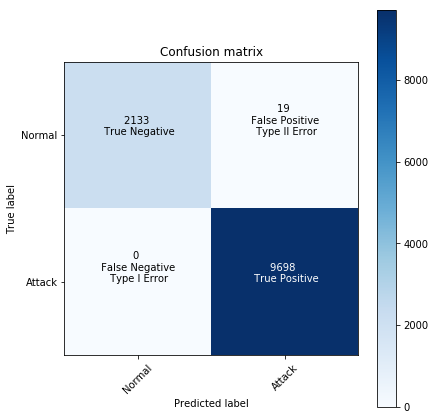

In [29]:
plot(actual_value = df_.loc[:,'Actual'].values.astype(int),
     pred_value = df_.loc[:,'Prediction'].values.astype(int))